Removed 2 duplicate rows
Best Model:
Alpha: 1.0, L1 Ratio: 1.0
RMSE: 69.45, R²: 0.60
Non-zero coefficients: 17.0


/var/folders/lc/0fqy2gd15rq5cbfwv1v18kz40000gp/T/ipykernel_1775/3862359670.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[cat_cols] = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])


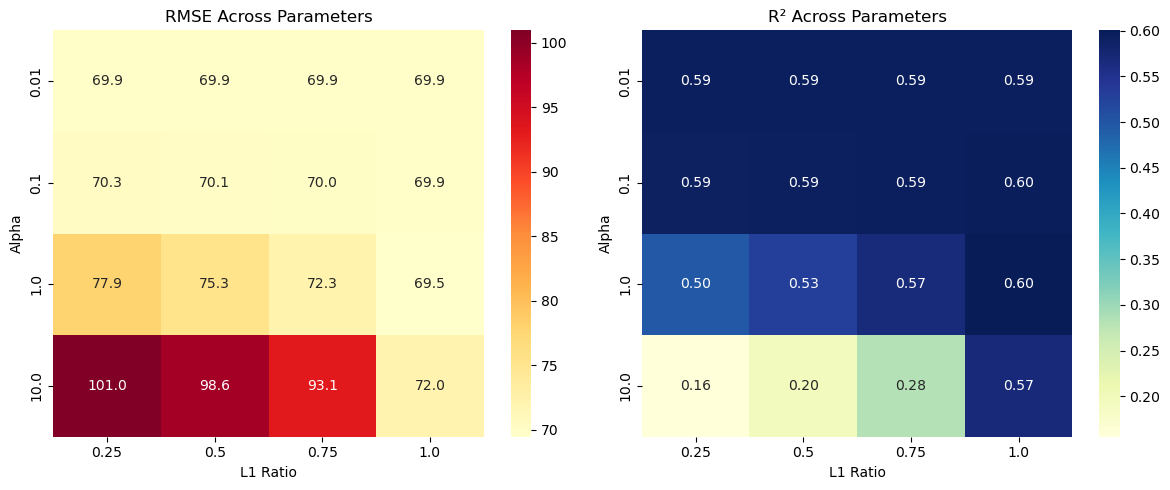

Performance Comparison:
  penalty     solver  accuracy  f1_score   roc_auc     auprc  num_coeff
0      l1  liblinear  0.798913  0.829493  0.883994  0.893280         19
1      l1       saga  0.798913  0.829493  0.883747  0.893147         19
2      l2  liblinear  0.798913  0.829493  0.883870  0.893158         20
3      l2       saga  0.798913  0.829493  0.883870  0.893158         20
k-NN Performance Evaluation:
   neighbors  accuracy  f1_score   roc_auc     auprc  \
0          1  0.733696  0.769953  0.732383  0.751497   
1          5  0.798913  0.831050  0.840491  0.833578   
2         10  0.804348  0.834862  0.874861  0.875008   

                                                 fpr  \
0                      [0.0, 0.273972602739726, 1.0]   
1  [0.0, 0.1232876712328767, 0.1780821917808219, ...   
2  [0.0, 0.0547945205479452, 0.0958904109589041, ...   

                                                 tpr  \
0                     [0.0, 0.7387387387387387, 1.0]   
1  [0.0, 0.44144144144144

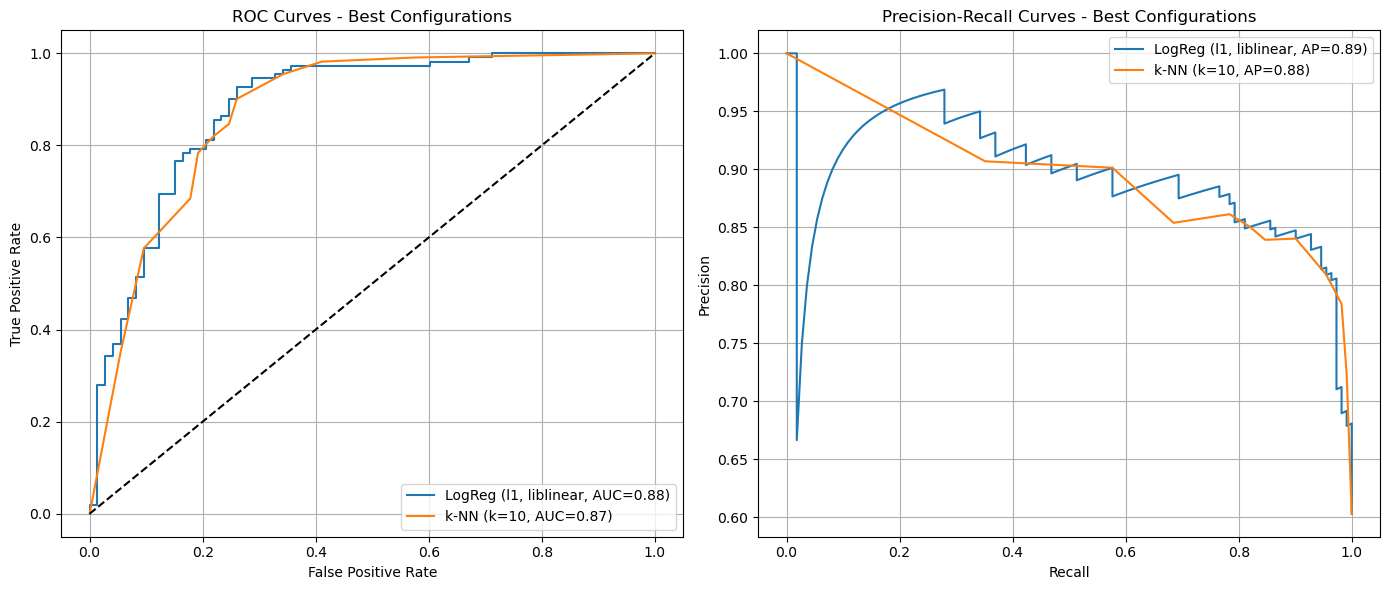

In [ ]:

import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Load data
heart_data = pd.read_csv('heart_disease_uci(1).csv')

#removing duplicates
initial_rows = len(heart_data)
heart_data = heart_data.drop_duplicates()
print(f"Removed {initial_rows - len(heart_data)} duplicate rows")

# Handle missing values in TARGET variables first
heart_data['chol'] = heart_data['chol'].fillna(heart_data['chol'].median())  # For regression target
heart_data['num'] = heart_data['num'].fillna(heart_data['num'].mode()[0])    # For classification target

# Separate features and targets
X = heart_data.drop(['chol', 'num'], axis=1)  
y_reg = heart_data['chol']                   
y_clf = heart_data['num']        

# Handle missing values in features
# For numerical features
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# For categorical features
cat_cols = X.select_dtypes(include=['object', 'category']).columns
X[cat_cols] = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# REGRESSION
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results=[]
alphas = [0.01, 0.1, 1, 10]
l1_ratios = [0.25, 0.5, 0.75, 1]

for alpha in alphas:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        model.fit(X_train_scaled, y_reg_train)

        y_pred = model.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred))
        r2 = r2_score(y_reg_test, y_pred)

        results.append({
            'alpha': alpha,
            'l1_ratio': l1_ratio,
            'rmse': rmse,
            'r2': r2,
            'non_zero_coef': sum(model.coef_ != 0)
        })

results_df = pd.DataFrame(results)  
best_model = results_df.loc[results_df['r2'].idxmax()]
print("Best Model:")
print(f"Alpha: {best_model['alpha']}, L1 Ratio: {best_model['l1_ratio']}")
print(f"RMSE: {best_model['rmse']:.2f}, R²: {best_model['r2']:.2f}")
print(f"Non-zero coefficients: {best_model['non_zero_coef']}")

# 7. Create heatmaps
plt.figure(figsize=(12, 5))     


# RMSE Heatmap 
plt.subplot(1, 2, 1)
heatmap_data = results_df.pivot(index="alpha", columns="l1_ratio", values="rmse")
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("RMSE Across Parameters")
plt.xlabel("L1 Ratio")
plt.ylabel("Alpha")

# R² Heatmap 
plt.subplot(1, 2, 2)
heatmap_data = results_df.pivot(index="alpha", columns="l1_ratio", values="r2")
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("R² Across Parameters")
plt.xlabel("L1 Ratio")
plt.ylabel("Alpha")

plt.tight_layout()
plt.show()


###Classification Models


y_clf_binary = (y_clf > 0).astype(int)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf_binary, test_size=0.2, random_state=42)

# Scale features for classification
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

# Logistic Regression Evaluation
results_2 = []
penalties = ['l1', 'l2']  
solvers = ['liblinear', 'saga'] 

for penalty in penalties:
    for solver in solvers:
        model = LogisticRegression(penalty=penalty, 
                                 solver=solver, 
                                 max_iter=1000,
                                 C=1.0,
                                 random_state=42)
        
        model.fit(X_train_clf_scaled, y_train_clf)
        
        y_pred = model.predict(X_test_clf_scaled)
        y_prob = model.predict_proba(X_test_clf_scaled)[:,1]
        
        
        fpr, tpr, _ = roc_curve(y_test_clf, y_prob)
        precision, recall, _ = precision_recall_curve(y_test_clf, y_prob)
        
        results_2.append({
            'penalty': penalty,
            'solver': solver,
            'accuracy': accuracy_score(y_test_clf, y_pred),
            'f1_score': f1_score(y_test_clf, y_pred),
            'roc_auc': auc(fpr, tpr),
            'auprc': average_precision_score(y_test_clf, y_prob),
            'fpr': fpr,
            'tpr': tpr,
            'precision': precision,
            'recall': recall,
            'num_coeff': sum(model.coef_[0] != 0),
            'coef': model.coef_[0]
        })

results2_df = pd.DataFrame(results_2)
print("Performance Comparison:")
print(results2_df[['penalty', 'solver', 'accuracy', 'f1_score', 'roc_auc', 'auprc', 'num_coeff']])


# k-NN Evaluation
neighbors = [1, 5, 10]
knn_results = []

for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_clf_scaled, y_train_clf)
    
    y_pred = model.predict(X_test_clf_scaled)
    y_prob = model.predict_proba(X_test_clf_scaled)[:,1]
    
    # Calculate metrics
    fpr, tpr, _ = roc_curve(y_test_clf, y_prob)
    precision, recall, _ = precision_recall_curve(y_test_clf, y_prob)
    
    knn_results.append({
        'neighbors': k,
        'accuracy': accuracy_score(y_test_clf, y_pred),
        'f1_score': f1_score(y_test_clf, y_pred),
        'roc_auc': auc(fpr, tpr),
        'auprc': average_precision_score(y_test_clf, y_prob),
        'fpr': fpr,
        'tpr': tpr,
        'precision': precision,
        'recall': recall
    })

knn_results_df = pd.DataFrame(knn_results)
print("k-NN Performance Evaluation:")
print(knn_results_df)


# Find best models
best_lr = results2_df.loc[results2_df['auprc'].idxmax()]
best_knn = knn_results_df.loc[knn_results_df['auprc'].idxmax()]

# Plot AUROC and AUPRC curves
plt.figure(figsize=(14, 6))

# AUROC Curve
plt.subplot(1, 2, 1)
plt.plot(best_lr['fpr'], best_lr['tpr'], 
         label=f'LogReg ({best_lr["penalty"]}, {best_lr["solver"]}, AUC={best_lr["roc_auc"]:.2f})')
plt.plot(best_knn['fpr'], best_knn['tpr'], 
         label=f'k-NN (k={best_knn["neighbors"]}, AUC={best_knn["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Best Configurations')
plt.legend()
plt.grid(True)

# AUPRC Curve
plt.subplot(1, 2, 2)
plt.plot(best_lr['recall'], best_lr['precision'], 
         label=f'LogReg ({best_lr["penalty"]}, {best_lr["solver"]}, AP={best_lr["auprc"]:.2f})')
plt.plot(best_knn['recall'], best_knn['precision'], 
         label=f'k-NN (k={best_knn["neighbors"]}, AP={best_knn["auprc"]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Best Configurations')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

